# NBA player of the week

Игроки недели с 1984-1985 по 2017-2018 сезон


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import time
import warnings
%matplotlib inline

### Задача 
На датасете,используя алгоритмы ML,научиться определять,является ли игрок защитником или нападающим

In [2]:
# Загрузим датасет
# https://www.kaggle.com/jacobbaruch/nba-player-of-the-week

dataNBA = pd.read_csv('data/NBA_player_of_the_week.csv', sep = ',', engine = 'python')

In [3]:
# Выкинем менее информативные столбцы и для большей наглядности поменяем некоторые столбцы местами

dataNBA = dataNBA.drop([
    'Conference',
    'Season short',
    'Real_value',
    'Draft Year'
   ], axis=1, errors='ignore')
dataNBA = dataNBA[['Player','Age','Height','Weight','Position','Seasons in league','Season','Date','Team']]

print(dataNBA.shape) 
print(dataNBA.columns)
dataNBA.head()

(1145, 9)
Index(['Player', 'Age', 'Height', 'Weight', 'Position', 'Seasons in league',
       'Season', 'Date', 'Team'],
      dtype='object')


,Player,Age,Height,Weight,Position,Seasons in league,Season,Date,Team
0,Micheal Ray Richardson,29,6-5,189,PG,6,1984-1985,"Apr 14, 1985",New Jersey Nets
1,Derek Smith,23,6-6,205,SG,2,1984-1985,"Apr 7, 1985",Los Angeles Clippers
2,Calvin Natt,28,6-6,220,F,5,1984-1985,"Apr 1, 1985",Denver Nuggets
3,Kareem Abdul-Jabbar,37,7-2,225,C,15,1984-1985,"Mar 24, 1985",Los Angeles Lakers
4,Larry Bird,28,6-9,220,SF,5,1984-1985,"Mar 17, 1985",Boston Celtics


 - `Age` – Возраст
 - `Data` – Дата,когда выбран лучшим игроком недели
 - `Draft Year` – Год драфта
 - `Height` – Рост
 - `Player` – Имя игрока 
 - `Position` – Позиция на поле
 - `Season` – Сезон
 - `Seasons in league` – Сезонов в лиге сыграно
 - `Team` – Название команды
 - `Weight` – Вес
					

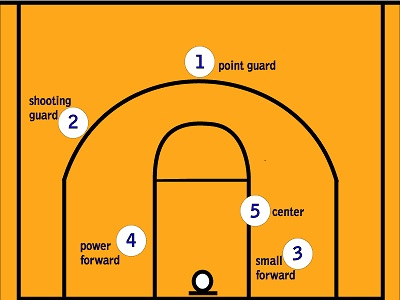

In [4]:
# Глянем картинку с позициями на поле :
from IPython.display import Image
Image("img/positions.jpg")

- PG(1)  - Разыгрывающий защитник (англ.  Point Guard), или первый номер
- SG(2)  - Атакующий защитник (англ. Shooting Guard), или второй номер
- SF(3)  - Лёгкий форвард (англ. Small Forward), или третий номер
- PF(4)  - Тяжёлый форвард (англ. Power Forward), или четвёртый номер
- C(5)   - Центровой (англ. Center), или пятый номер

Доп обозначения :
- G   - PG или  SG
- F   - SF или PF
- FC  - PF или C

In [5]:
# Определим некоторые вспомогательные функции,необходимые для приведения веса и роста к нужным единицам измерения

def convert_height(height):
    if len(re.split('cm',height)) == 1:
        height = convert_fais_to_cms(height,'-')
    else:
        height = height[:3]  # обрезаем подстроку 'cm'
    return round(int(height))

def convert_fais_to_cms(fai,delimeter): # fai - feet and inches
    # константы :
    cms_in_one_inch = 2.54
    cms_in_one_foot = 30.48 
    # перевод :
    feet,inches = re.split(delimeter,str(fai),maxsplit=1)  # макс кол-во разбиений = 1
    height_in_cms = int(feet) * cms_in_one_foot + int(inches) * cms_in_one_inch;
    return height_in_cms

def convert_weight(weight):
    lb = 0.45359237  # кг в 1-ом фунте 
    weight = re.split('kg',weight)
    if len(weight) == 1:
        weight = int(weight[0]) * lb 
    else:
        weight = int(weight[0])
    return round(weight)

In [6]:
# Проёдёмся по датасету и приведём вес к "кг",а рост к "см"

for i in range(dataNBA.shape[0]):
    dataNBA.at[i,'Height'] = convert_height(dataNBA.at[i,'Height'])
    dataNBA.at[i,'Weight'] = convert_weight(dataNBA.at[i,'Weight'])

In [7]:
# Посмотрим первые строки датасета
dataNBA.head()

,Player,Age,Height,Weight,Position,Seasons in league,Season,Date,Team
0,Micheal Ray Richardson,29,195,86,PG,6,1984-1985,"Apr 14, 1985",New Jersey Nets
1,Derek Smith,23,198,93,SG,2,1984-1985,"Apr 7, 1985",Los Angeles Clippers
2,Calvin Natt,28,198,100,F,5,1984-1985,"Apr 1, 1985",Denver Nuggets
3,Kareem Abdul-Jabbar,37,218,102,C,15,1984-1985,"Mar 24, 1985",Los Angeles Lakers
4,Larry Bird,28,205,100,SF,5,1984-1985,"Mar 17, 1985",Boston Celtics


In [8]:
# Теперь посмотрим сколько уникальных записей,проверяя по имени игрока
dataNBA.Player.unique().shape

(274,)

In [9]:
# Маловато,но что поделать.
# Теперь выкинем повторения и сравним 
dataNBA = dataNBA[~dataNBA.duplicated(subset=['Player'],keep='first')]
dataNBA.shape

(274, 9)

In [10]:
# Дропнем ненужные для дальнейшей работы колонки и посмотрим на текущее состояние датасета
dataNBA = dataNBA.drop([ 'Player',
                         'Season',
                         'Date'  ], axis=1, errors='ignore')
dataNBA

,Age,Height,Weight,Position,Seasons in league,Team
0,29,195,86,PG,6,New Jersey Nets
1,23,198,93,SG,2,Los Angeles Clippers
2,28,198,100,F,5,Denver Nuggets
3,37,218,102,C,15,Los Angeles Lakers
4,28,205,100,SF,5,Boston Celtics
5,26,193,86,SG,4,Utah Jazz
6,24,190,77,PG,2,Golden State Warriors
7,25,198,105,SF,3,Dallas Mavericks
8,25,205,116,PG,5,Los Angeles Lakers
9,25,200,91,SF,2,Atlanta Hawks


In [11]:
# Проверим типы столбцов
dataNBA.dtypes

Age                   int64
Height               object
Weight               object
Position             object
Seasons in league     int64
Team                 object
dtype: object

In [12]:
# Приведём вес и рост к int
dataNBA['Weight'] = dataNBA.Weight.astype(int)
dataNBA['Height'] = dataNBA.Height.astype(int)

In [13]:
# Проверим типы теперь
dataNBA.dtypes

Age                   int64
Height                int32
Weight                int32
Position             object
Seasons in league     int64
Team                 object
dtype: object

In [14]:
dataNBA.describe()

,Age,Height,Weight,Seasons in league
count,274.000000,274.000000,274.000000,274.000000
mean,25.266423,200.054745,99.364964,3.729927
std,3.065554,9.559948,13.345988,2.586252
min,19.000000,175.000000,68.000000,0.000000
25%,23.000000,193.000000,88.000000,2.000000
50%,25.000000,200.000000,100.000000,3.000000
75%,27.000000,208.000000,109.000000,5.000000
max,37.000000,228.000000,147.000000,15.000000


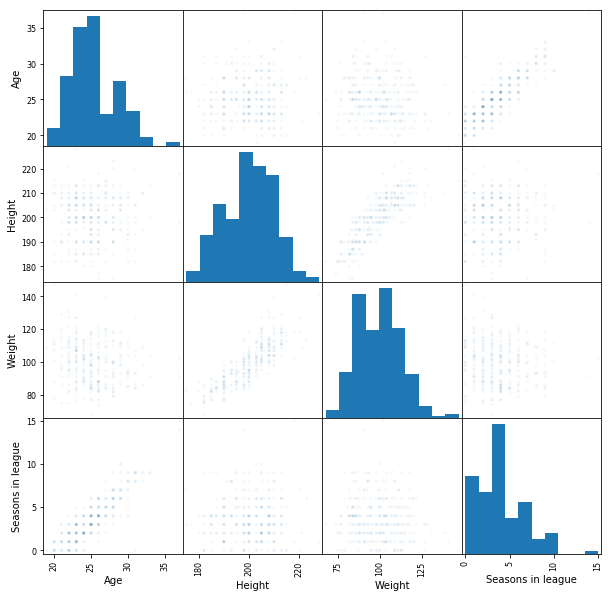

In [15]:
# Нарисуем графики числовых столбцов друг от друга
from pandas.plotting import scatter_matrix
scatter_matrix(dataNBA, alpha = .05, figsize = (10, 10))
pass

In [16]:
# Корреляция столбцов
dataNBA.corr()

,Age,Height,Weight,Seasons in league
Age,1.000000,0.025998,-0.135251,0.856909
Height,0.025998,1.000000,0.826658,0.040009
Weight,-0.135251,0.826658,1.000000,-0.085536
Seasons in league,0.856909,0.040009,-0.085536,1.000000


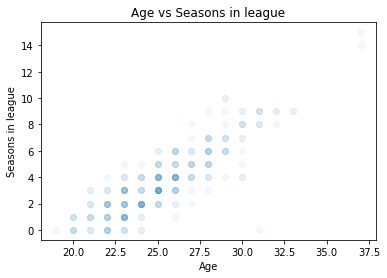

In [17]:
# Построим график зав-ти кол-ва сезонов в лиге от возраста

plt.plot(dataNBA['Age'], dataNBA['Seasons in league'], 'o', alpha = 0.05)
plt.xlabel('Age')
plt.ylabel('Seasons in league')
plt.title('Age vs Seasons in league')
pass

In [18]:
# Ближе к нашей задаче :

In [19]:
# Условно поделим игроков на защитников и нападающих
# Для этого сначала уберём игроков с позицией 'GF' или 'G-F' - это универсалы,которые играют(ли) как в защите,
# так и в нападении.

dataNBA = dataNBA[(dataNBA.Position != 'GF') & (dataNBA.Position != 'G-F')] 

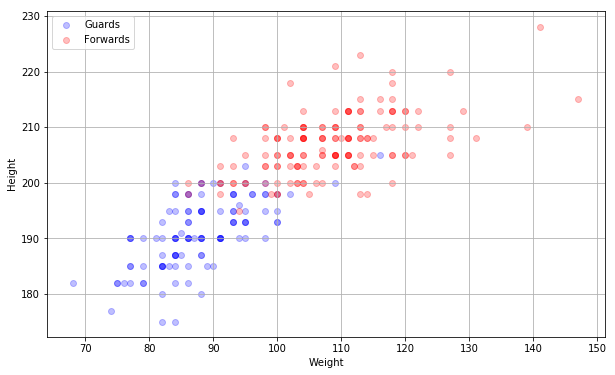

In [20]:
# Теперь все игроков с позициями  'PG','SG','G' "запишем" в защитники,
# а с позициями 'SF','PF','F','C','FC','F-C' в нападающие
# Посмотрим для нападающих и защитников зависимость роста от веса

G = dataNBA[(dataNBA['Position'] == 'PG' ) | 
            (dataNBA['Position'] == 'SG' ) | 
            (dataNBA['Position'] == 'G'  ) ]

F = dataNBA[(dataNBA['Position'] == 'SF' ) |
            (dataNBA['Position'] == 'PF' ) |
            (dataNBA['Position'] == 'F'  ) | 
            (dataNBA['Position'] == 'C'  ) |
            (dataNBA['Position'] == 'FC' ) |
            (dataNBA['Position'] == 'F-C'  )]
            
plt.figure(figsize = (10, 6)) 
plt.scatter(G['Weight'],G['Height'],
            alpha = 0.25,
            label = 'Guards',
            color = 'b')

plt.scatter(F['Weight'],F['Height'],
            alpha = 0.25,
            label = 'Forwards',
            color = 'r')

plt.xlabel('Weight')
plt.ylabel('Height')
plt.legend()
plt.grid()

In [21]:
dataNBA.describe(include = ['object']) # Признаки с типом object 

,Position,Team
count,259,259
unique,9,35
top,G,Milwaukee Bucks
freq,45,14


In [22]:
dataNBA.describe(include = 'all') # Все признаки

,Age,Height,Weight,Position,Seasons in league,Team
count,259.000000,259.000000,259.000000,259,259.000000,259
unique,NaN,NaN,NaN,9,NaN,35
top,NaN,NaN,NaN,G,NaN,Milwaukee Bucks
freq,NaN,NaN,NaN,45,NaN,14
mean,25.266409,200.015444,99.386100,NaN,3.710425,NaN
std,3.104521,9.815732,13.694534,NaN,2.600896,NaN
min,19.000000,175.000000,68.000000,NaN,0.000000,NaN
25%,23.000000,193.000000,88.000000,NaN,2.000000,NaN
50%,25.000000,200.000000,100.000000,NaN,3.000000,NaN
75%,27.000000,208.000000,109.000000,NaN,5.000000,NaN


In [23]:
dataNBA['Team'].unique()  # Уникальные команды

array(['New Jersey Nets', 'Los Angeles Clippers', 'Denver Nuggets',
       'Los Angeles Lakers', 'Boston Celtics', 'Utah Jazz',
       'Golden State Warriors', 'Dallas Mavericks', 'Atlanta Hawks',
       'Washington Bullets', 'Chicago Bulls', 'Cleveland Cavaliers',
       'Detroit Pistons', 'Milwaukee Bucks', 'Seattle SuperSonics',
       'New York Knicks', 'Philadelphia Sixers', 'Phoenix Suns',
       'Indiana Pacers', 'Portland Trail Blazers', 'San Antonio Spurs',
       'Sacramento Kings', 'Houston Rockets', 'Miami Heat',
       'Orlando Magic', 'Charlotte Hornets', 'Minnesota Timberwolves',
       'Toronto Raptors', 'Washington Wizards', 'New Orleans Hornets',
       'Memphis Grizzlies', 'Charlotte Bobcats', 'Oklahoma City Thunder',
       'Brooklyn Nets', 'New Orleans Pelicans'], dtype=object)

# Задача

In [24]:
# Поделим колонки на категориальные и числовые
categorical_columns = [c for c in dataNBA.columns if dataNBA[c].dtype.name == 'object'] #
numerical_columns   = [c for c in dataNBA.columns if dataNBA[c].dtype.name != 'object']
print('категориальные : ',categorical_columns)
print('числовые : ',numerical_columns)

категориальные :  ['Position', 'Team']
числовые :  ['Age', 'Height', 'Weight', 'Seasons in league']


In [25]:
for c in categorical_columns:
    print(c, dataNBA[c].unique())

Position ['PG' 'SG' 'F' 'C' 'SF' 'PF' 'G' 'FC' 'F-C']
Team ['New Jersey Nets' 'Los Angeles Clippers' 'Denver Nuggets'
 'Los Angeles Lakers' 'Boston Celtics' 'Utah Jazz' 'Golden State Warriors'
 'Dallas Mavericks' 'Atlanta Hawks' 'Washington Bullets' 'Chicago Bulls'
 'Cleveland Cavaliers' 'Detroit Pistons' 'Milwaukee Bucks'
 'Seattle SuperSonics' 'New York Knicks' 'Philadelphia Sixers'
 'Phoenix Suns' 'Indiana Pacers' 'Portland Trail Blazers'
 'San Antonio Spurs' 'Sacramento Kings' 'Houston Rockets' 'Miami Heat'
 'Orlando Magic' 'Charlotte Hornets' 'Minnesota Timberwolves'
 'Toronto Raptors' 'Washington Wizards' 'New Orleans Hornets'
 'Memphis Grizzlies' 'Charlotte Bobcats' 'Oklahoma City Thunder'
 'Brooklyn Nets' 'New Orleans Pelicans']


In [26]:
# Медианы числовых колонок
dataNBA.median(axis = 0)

Age                   25.0
Height               200.0
Weight               100.0
Seasons in league      3.0
dtype: float64

In [27]:
# Заполним медианами возможные NA значания
dataNBA = dataNBA.fillna(dataNBA.median(axis = 0), axis = 0)

In [28]:
dataNBA[numerical_columns].count(axis=0)

Age                  259
Height               259
Weight               259
Seasons in league    259
dtype: int64

In [29]:
dataNBA[categorical_columns].count(axis = 0)

Position    259
Team        259
dtype: int64

In [30]:
dataNBA['Position'].unique()

array(['PG', 'SG', 'F', 'C', 'SF', 'PF', 'G', 'FC', 'F-C'], dtype=object)

In [31]:
# Сделаем колонку 'Position' бинарной - защитников обозначим за 0,нападающих за 1

dataNBA.at[(dataNBA['Position'] == 'PG' ) | 
           (dataNBA['Position'] == 'SG' ) | 
           (dataNBA['Position'] == 'G'  ), 'Position'] = 0


dataNBA.at[(dataNBA['Position'] == 'SF' ) |
           (dataNBA['Position'] == 'PF' ) |
           (dataNBA['Position'] == 'F'  ) | 
           (dataNBA['Position'] == 'C'  ) |
           (dataNBA['Position'] == 'FC' ) |
           (dataNBA['Position'] == 'F-C'  ),'Position'] = 1
dataNBA['Position'].describe()

count     259
unique      2
top         1
freq      147
Name: Position, dtype: int64

# Векторизация
Нужно что-то сделать с категориальными (номинальными) признаками

In [32]:
dataNBA_describe = dataNBA.describe(include =[object])
binary_columns = [c for c in categorical_columns if dataNBA_describe[c]['unique']==2]
nonbinary_columns = [c for c in categorical_columns if dataNBA_describe[c]['unique']>2]
print ('Бинарные- ',binary_columns)
print ('Небинарные- ',nonbinary_columns)

Бинарные-  ['Position']
Небинарные-  ['Team']


In [33]:
dataNBA_nonbinary = pd.get_dummies(dataNBA[nonbinary_columns])
print(dataNBA_nonbinary.columns)

Index(['Team_Atlanta Hawks', 'Team_Boston Celtics', 'Team_Brooklyn Nets',
       'Team_Charlotte Bobcats', 'Team_Charlotte Hornets',
       'Team_Chicago Bulls', 'Team_Cleveland Cavaliers',
       'Team_Dallas Mavericks', 'Team_Denver Nuggets', 'Team_Detroit Pistons',
       'Team_Golden State Warriors', 'Team_Houston Rockets',
       'Team_Indiana Pacers', 'Team_Los Angeles Clippers',
       'Team_Los Angeles Lakers', 'Team_Memphis Grizzlies', 'Team_Miami Heat',
       'Team_Milwaukee Bucks', 'Team_Minnesota Timberwolves',
       'Team_New Jersey Nets', 'Team_New Orleans Hornets',
       'Team_New Orleans Pelicans', 'Team_New York Knicks',
       'Team_Oklahoma City Thunder', 'Team_Orlando Magic',
       'Team_Philadelphia Sixers', 'Team_Phoenix Suns',
       'Team_Portland Trail Blazers', 'Team_Sacramento Kings',
       'Team_San Antonio Spurs', 'Team_Seattle SuperSonics',
       'Team_Toronto Raptors', 'Team_Utah Jazz', 'Team_Washington Bullets',
       'Team_Washington Wizards'],
 

# Нормализация количественных признаков

In [34]:
dataNBA_numerical = dataNBA[numerical_columns]
dataNBA_numerical.describe()

,Age,Height,Weight,Seasons in league
count,259.000000,259.000000,259.000000,259.000000
mean,25.266409,200.015444,99.386100,3.710425
std,3.104521,9.815732,13.694534,2.600896
min,19.000000,175.000000,68.000000,0.000000
25%,23.000000,193.000000,88.000000,2.000000
50%,25.000000,200.000000,100.000000,3.000000
75%,27.000000,208.000000,109.000000,5.000000
max,37.000000,228.000000,147.000000,15.000000


In [35]:
dataNBA_numerical = (dataNBA_numerical - dataNBA_numerical.mean(axis = 0))/dataNBA_numerical.std(axis = 0)

In [36]:
dataNBA_numerical.describe()

,Age,Height,Weight,Seasons in league
count,2.590000e+02,2.590000e+02,2.590000e+02,2.590000e+02
mean,2.177580e-16,-2.829140e-16,3.403541e-16,2.186153e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.018478e+00,-2.548505e+00,-2.291871e+00,-1.426595e+00
25%,-7.300350e-01,-7.147143e-01,-8.314339e-01,-6.576291e-01
50%,-8.581331e-02,-1.573394e-03,4.482808e-02,-2.731462e-01
75%,5.584084e-01,8.134448e-01,7.020246e-01,4.958197e-01
max,3.779517e+00,2.850990e+00,3.476854e+00,4.340649e+00


In [37]:
dataNBA = pd.concat((dataNBA_numerical, dataNBA_nonbinary, dataNBA[binary_columns]), axis = 1)
dataNBA.describe()

,Age,Height,Weight,Seasons in league,Team_Atlanta Hawks,Team_Boston Celtics,Team_Brooklyn Nets,Team_Charlotte Bobcats,Team_Charlotte Hornets,Team_Chicago Bulls,...,Team_Philadelphia Sixers,Team_Phoenix Suns,Team_Portland Trail Blazers,Team_Sacramento Kings,Team_San Antonio Spurs,Team_Seattle SuperSonics,Team_Toronto Raptors,Team_Utah Jazz,Team_Washington Bullets,Team_Washington Wizards
count,2.590000e+02,2.590000e+02,2.590000e+02,2.590000e+02,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,...,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000
mean,2.177580e-16,-2.829140e-16,3.403541e-16,2.186153e-17,0.034749,0.038610,0.003861,0.007722,0.015444,0.023166,...,0.034749,0.027027,0.030888,0.027027,0.034749,0.027027,0.015444,0.038610,0.015444,0.034749
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.183498,0.193037,0.062137,0.087704,0.123549,0.150722,...,0.183498,0.162476,0.173349,0.162476,0.183498,0.162476,0.123549,0.193037,0.123549,0.183498
min,-2.018478e+00,-2.548505e+00,-2.291871e+00,-1.426595e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.300350e-01,-7.147143e-01,-8.314339e-01,-6.576291e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-8.581331e-02,-1.573394e-03,4.482808e-02,-2.731462e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.584084e-01,8.134448e-01,7.020246e-01,4.958197e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.779517e+00,2.850990e+00,3.476854e+00,4.340649e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
dataNBA['Position'] = dataNBA.Position.astype(int)

# X и y

In [39]:
# Выкинем столбец 'Position'
X = dataNBA.drop(('Position'), axis = 1)
y = dataNBA['Position']
feature_names = X.columns
feature_names

Index(['Age', 'Height', 'Weight', 'Seasons in league', 'Team_Atlanta Hawks',
       'Team_Boston Celtics', 'Team_Brooklyn Nets', 'Team_Charlotte Bobcats',
       'Team_Charlotte Hornets', 'Team_Chicago Bulls',
       'Team_Cleveland Cavaliers', 'Team_Dallas Mavericks',
       'Team_Denver Nuggets', 'Team_Detroit Pistons',
       'Team_Golden State Warriors', 'Team_Houston Rockets',
       'Team_Indiana Pacers', 'Team_Los Angeles Clippers',
       'Team_Los Angeles Lakers', 'Team_Memphis Grizzlies', 'Team_Miami Heat',
       'Team_Milwaukee Bucks', 'Team_Minnesota Timberwolves',
       'Team_New Jersey Nets', 'Team_New Orleans Hornets',
       'Team_New Orleans Pelicans', 'Team_New York Knicks',
       'Team_Oklahoma City Thunder', 'Team_Orlando Magic',
       'Team_Philadelphia Sixers', 'Team_Phoenix Suns',
       'Team_Portland Trail Blazers', 'Team_Sacramento Kings',
       'Team_San Antonio Spurs', 'Team_Seattle SuperSonics',
       'Team_Toronto Raptors', 'Team_Utah Jazz', 'Team_Wa

In [40]:
print(X.shape)
print(y.shape)
N, d = X.shape

(259, 39)
(259,)


In [41]:
type(X)

pandas.core.frame.DataFrame

In [42]:
type(y)

pandas.core.series.Series

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

181 78


In [44]:
181 + 78

259

#  KNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
#knn.set_params(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [46]:
y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)

err_train = np.mean(y_train != y_train_predict)
err_test  = np.mean(y_test  != y_test_predict)

print(err_train, err_test)

0.0497237569061 0.153846153846


In [47]:
err_test = 1 - knn.score(X_test, y_test)
err_test

0.15384615384615385

In [48]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_test_predict))

[[28  5]
 [ 7 38]]


In [49]:
confusion_matrix([0,1,0,1,0], [0,1,0,0,0])

array([[3, 0],
       [1, 1]], dtype=int64)

### Подбор оптимального кол-ва соседей для метода

In [50]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print('лучшая ошибка',best_cv_err)
print('лучшее кол-во соседей из представленных - ',best_n_neighbors)

лучшая ошибка 0.0497237569061
лучшее кол-во соседей из представленных -  25


In [51]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))

print(err_train, err_test)

0.0552486187845 0.0769230769231


Было : 0.153846153846 (при n_neighbors = 10)

Стало : 0.0769230769231 (при n_neighbors = 25)

# Multilayer perceptron (MLP)

In [52]:
#  Разделим входные данные на обучающую и тестовую выборки 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [53]:
# Создадим классификатор с одним скрытым слоем размерностью 10 и активационной функцией logistic 
from sklearn.neural_network import MLPClassifier

perc = MLPClassifier(hidden_layer_sizes=(10,))
perc.activation='logistic'
perc.max_iter=10000000

In [57]:
#  Обучим классификатор, получены значения y_pred для проверки на тестовой выборке
perc=perc.fit(x_train, y_train)

In [58]:
y_pred = perc.predict(x_test)

### Проверяем качество классификатора  

In [59]:
# Посмотрим тестовую выборку y
print(y_test)

1115    1
20      1
15      1
129     0
693     1
251     0
403     1
981     1
102     0
185     1
731     0
632     1
1096    0
1099    1
273     0
544     0
334     0
861     0
599     0
90      1
0       0
868     1
692     0
414     0
737     1
1061    1
557     0
420     1
18      1
392     1
77      1
1073    1
147     1
677     1
415     0
878     1
723     1
904     0
1014    0
177     1
812     1
667     1
125     0
921     0
457     0
491     1
67      1
417     1
227     1
101     1
542     1
936     1
Name: Position, dtype: int32


Выведем выборку с предсказанием. Cоздадим масссив y_matched,куда положим угаданные нейронной сетью позиции игроков.

In [61]:
print(y_pred)
y_matched = []
y_matched.append(y_pred==y_test)

[1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1
 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1]


In [63]:
print(1 - perc.score(x_test, y_test))

0.0576923076923


Как видно из результата ошибка составила 5,77% (кол-во записей в тестовой выборке = 52)

In [80]:
# Выведем марицу неточностей(confusion matrix)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_pred, y_test))

[[18  1]
 [ 2 31]]


 Как видно из матрицы диагональные элементы явно выражены, значит в целом классификатор определяет решения верно.

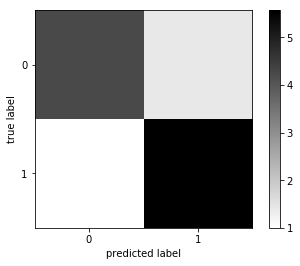

In [86]:
M = confusion_matrix(y_test, y_pred)
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.grid(False)
plt.xticks(range(len(M[0])))
plt.yticks(range(len(M)))
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.colorbar()
pass

К сожалению,в связи с тем,что кол-во записей в датасете после обработке невелико мы имеем маленькую матрицу неточносте и по ней можно сделать не так много выводов

# Подбор гиперпараметров

 Теперь попробуем классификатор с большим числом параметров

In [90]:
perc = MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [91]:
perc=perc.fit(x_train, y_train)
y_pred = perc.predict(x_test)
yy = []
yy.append(y_pred==y_test)
print(yy)
print(1 - perc.score(x_test, y_test))

[1115     True
20       True
15       True
129      True
693      True
251      True
403      True
981      True
102      True
185      True
731      True
632      True
1096     True
1099     True
273      True
544      True
334      True
861      True
599     False
90       True
0        True
868      True
692      True
414     False
737      True
1061     True
557      True
420      True
18       True
392      True
77       True
1073     True
147     False
677      True
415      True
878      True
723      True
904     False
1014     True
177      True
812      True
667      True
125      True
921      True
457      True
491      True
67       True
417      True
227      True
101      True
542      True
936      True
Name: Position, dtype: bool]
0.0769230769231


Теперь шибка незначительно увеличилась и составляет 7,6% вместо прежних 5,77%

### Подберем оптимальное значение параметра регуляризации alpha

In [92]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
for alpha in alpha_arr:
    perc = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', random_state = 42)
    perc.fit(x_train, y_train)

    y_train_pred = perc.predict(x_train)
    y_test_pred = perc.predict(x_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

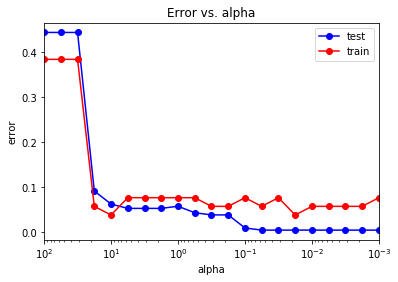

In [93]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'test')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'train')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

Ошибка на тренировочной выборке и на тестовой практически одинаковая.
Переобучение на таких данных невозможно. Недообучение возможно, так как ошибка все же падает с уменьшением alpha.

Выведем минимальное значение ошибки:

In [100]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.0048309178744 0.0384615384615


Выведем оптимальное значение alpha:

In [105]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[  0.01778279  10.        ]


In [106]:
alpha_opt = alpha_opt[0]
print(alpha_opt)

0.0177827941004


###  Классификатор при найденном оптимальном значении alpha:

Повторим обучение:

In [107]:
perc = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
perc.fit(x_train, y_train)

y_train_pred = perc.predict(x_train)
y_test_pred = perc.predict(x_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.0048309178744
0.0384615384615


###  Матрица рассогласования:

In [108]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[19  1]
 [ 1 31]]


Пусть матрица и небольшая,но всё же видно,что диагональные элементы явно выражены, значит в целом классификатор определяет решения верно. 
Результат немного улучшается в лучшую сторону по сравнению с прошлой матрицей рассогласования, выведенной при использовании не оптимального альфа значения у прошлого классификатора.

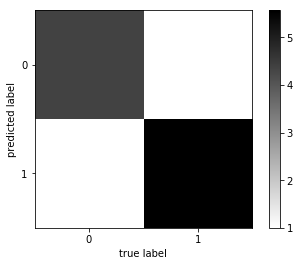

In [109]:
M = confusion_matrix(y_test_pred, y_test)
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(2))
plt.yticks(range(2))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass

In [111]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.95      0.95      0.95        20
          1       0.97      0.97      0.97        32

avg / total       0.96      0.96      0.96        52



Видно,что точность определения нападающего немного выше,чем защитника.
Следовательно и агрегированная оценка f1-score складываемая из precision recall оценок получается лучше для нападающих 

## Размер слоя

Посмотрим зависимость ошибки от количества нейронов

In [113]:
size_arr = (1, 2, 10, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 700, 1000)
test_err = []
train_err = []
for size in size_arr:
    mlp_model = MLPClassifier(hidden_layer_sizes = (int(size),), solver = 'lbfgs', activation = 'logistic', random_state = 42)
    mlp_model.fit(x_train, y_train)

    y_train_pred = mlp_model.predict(x_train)
    y_test_pred = mlp_model.predict(x_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

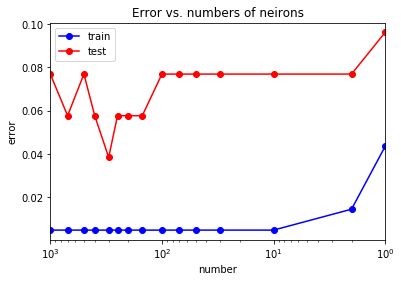

In [114]:
plt.semilogx(size_arr, train_err, 'b-o', label = 'train')
plt.semilogx(size_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.max(size_arr), np.min(size_arr)])
plt.title('Error vs. numbers of neirons')
plt.xlabel('number')
plt.ylabel('error')
plt.legend()
pass  

При размере слоя около 300 наблюдается наибольшее переобучение. Ошибки для тестовой выборки колеблются от ~4% до ~10%

# 3 задание (TREES)

### Random forest

Разделим входные данные на обучающюу и тестовую выборки

In [115]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Обучаем классификатор вида Random Forest. Число деревьев = 4

In [116]:
from sklearn import ensemble
rf_model = ensemble.RandomForestClassifier(n_estimators = 4)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Посчитаем и выведем ошибку на обучающей выборке

In [120]:
err_train = np.mean(y_train != rf_model.predict(X_train))
print(err_train)

0.0276243093923


Посчитаем и выведем ошибку на тестовой выборке

In [121]:
err_test  = np.mean(y_test  != rf_model.predict(X_test))
print(err_test)

0.153846153846


На обучающей выборке ошибка составила 2,7%, что пока что самый лучший достигнутый результат из всех алгоритмов,НО! на тестовой выборке ошибка составила целых 15,4% (худший показатель среди используемых методов). Так как ошибка на обучающей выборке существо меньше, чем на тестовой, наблюдается переобучение. Посмотрим зависимость ошибки от количества деревьев.

In [123]:
from sklearn import ensemble
size_arr = np.arange(10,500,10)
test_err = []
train_err = []
for size in size_arr:
    rf_model = ensemble.RandomForestClassifier(n_estimators = int(size))
    rf_model.fit(X_train, y_train)

    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

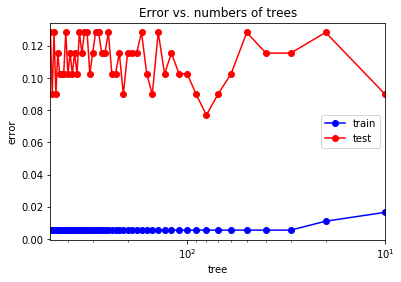

In [124]:
plt.semilogx(size_arr, train_err, 'b-o', label = 'train')
plt.semilogx(size_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.max(size_arr), np.min(size_arr)])
plt.title('Error vs. numbers of trees')
plt.xlabel('tree')
plt.ylabel('error')
plt.legend()
pass

In [125]:
# Найдем минимальное значение ошибки и количество деревьев, на котором оно достигается
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.00552486187845 0.0769230769231


In [126]:
trees_opt = size_arr[test_err == min_test_err]
trees_opt = trees_opt[0]
print(trees_opt)

80


Из графика следует, что начиная с примерно 80 деревьев имеет место явное переобучение, ошибка на обучающей выборке стала равна постоянной и почти равной 0, но ошибка на тестовой выборке так и остается в пределах 7-13% не улучшаясь.

# Extremely Random Forests

Обучим классификатор вида Extremely Randomized Trees.

In [129]:
ert_model = ensemble.ExtraTreesClassifier(n_estimators = 1)
ert_model.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Посчитаем и выведем ошибку на обучающей выборке

In [137]:
err_train = np.mean(y_train != rf_model.predict(X_train))
print(err_train)

0.00552486187845


Посчитаем и выведем ошибку на тестовой выборке

In [138]:
err_test  = np.mean(y_test  != ert_model.predict(X_test))
print(err_test)

0.179487179487


 На данном дереве наблюдается эффект сильного переобучения, так как на тестовой выборке мы видим результат сильно хуже, чем на обучающей.Попробуем посмотреть зависимость ошибки от количества деревьев

In [139]:
size_arr = np.arange(10,500,10)
test_err = []
train_err = []
for size in size_arr:
    ert_model = ensemble.ExtraTreesClassifier(n_estimators = int(size))
    ert_model.fit(X_train, y_train)

    y_train_pred = ert_model.predict(X_train)
    y_test_pred = ert_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

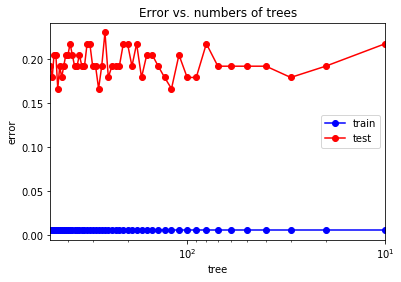

In [140]:
plt.semilogx(size_arr, train_err, 'b-o', label = 'train')
plt.semilogx(size_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.max(size_arr), np.min(size_arr)])
plt.title('Error vs. numbers of trees')
plt.xlabel('tree')
plt.ylabel('error')
plt.legend()
pass

Найдем минимальное значение ошибки и количество деревьев, на котором оно достигается

In [141]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.00552486187845 0.166666666667


In [142]:
trees_opt = size_arr[test_err == min_test_err]
trees_opt = trees_opt[0]
print(trees_opt)

120


Из графика следует, что ошибка на обучающей выборке близка к 0 и не зависит от кол-ва деревьев. Но при этом ошибка на тестовой выборке существенно не меняется прмерно с 40 деревьев и колеблется около 19% (немного больше предыдущего алгоритма). Однако лучшее значение ошибки ~16.7%,что сильно хуже результата для пред. алгоритма.

# Ada Boost Classifier

Обучаем классификатор вида AdaBoost

In [143]:
ab_model = ensemble.AdaBoostClassifier(n_estimators = 50)
ab_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Посчитаем и выведем ошибку на обучающей выборке

In [144]:
err_train = np.mean(y_train != ab_model.predict(X_train))
print(err_train)

0.00552486187845


Посчитаем и выведем ошибку на тестовой выборке

In [145]:
err_test  = np.mean(y_test  != ab_model.predict(X_test))
print(err_test)

0.141025641026


На данном дереве снова наблюдается эффект сильного переобучения, что означает, что классификатор чаще определяет позицию игрока неверно. Снова посмотрим зависимость ошибки от количества деревьев

In [146]:
size_arr = np.arange(10,500,10)
test_err = []
train_err = []
for size in size_arr:
    ada_model = ensemble.AdaBoostClassifier(n_estimators = int(size))
    ada_model.fit(X_train, y_train)

    y_train_pred = ada_model.predict(X_train)
    y_test_pred = ada_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

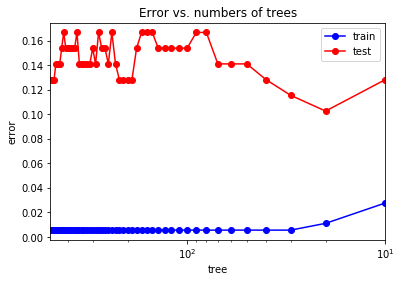

In [147]:
plt.semilogx(size_arr, train_err, 'b-o', label = 'train')
plt.semilogx(size_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.max(size_arr), np.min(size_arr)])
plt.title('Error vs. numbers of trees')
plt.xlabel('tree')
plt.ylabel('error')
plt.legend()
pass

Найдем минимальное значение ошибки и количество деревьев, на котором оно достигается

In [148]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.00552486187845 0.102564102564


In [149]:
trees_opt = size_arr[test_err == min_test_err]
trees_opt = trees_opt[0]
print(trees_opt)

20


 Из графика следует, что ошибка на обучающей выборке вначале спадает с 2,5% до 0,5% и далее,начиная с 30 деревьев остаётся постоянной. Но при этом ошибка на тестовой выборке начинает заметно расти с 20 деревьев,поднимается до уровня в 14% и далее колеблется около этого значения,что немного лучше чем для Extremely Random Forests.

# Gradient Boosting Trees

Обучаем классификатор вида Gradient Boosted Trees. Число деревьев = 100

In [150]:
gbt_model = ensemble.GradientBoostingClassifier(n_estimators = 100, max_depth = 2, learning_rate= 0.4)
gbt_model.fit(X_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.4, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Посчитаем и выведем ошибку на обучающей выборке

In [151]:
err_train = np.mean(y_train != gbt_model.predict(X_train))
print(err_train)

0.00552486187845


Посчитаем и выведем ошибку на тестовой выборке

In [152]:
err_test  = np.mean(y_test  != gbt_model.predict(X_test))
print(err_test)

0.128205128205


На данном дереве опять же наблюдается эффектсильного переобучения.Посмотрим зависимость ошибки от количества деревьев

In [153]:
size_arr = np.arange(10,500,10)
test_err = []
train_err = []
for size in size_arr:
    gbt_model = ensemble.GradientBoostingClassifier(n_estimators = int(size))
    gbt_model.fit(X_train, y_train)

    y_train_pred = gbt_model.predict(X_train)
    y_test_pred = gbt_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

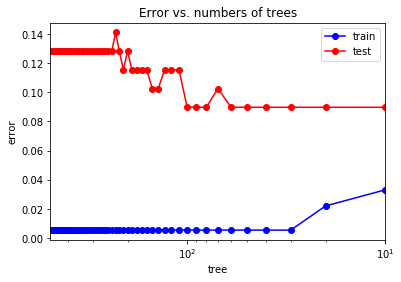

In [154]:
plt.semilogx(size_arr, train_err, 'b-o', label = 'train')
plt.semilogx(size_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.max(size_arr), np.min(size_arr)])
plt.title('Error vs. numbers of trees')
plt.xlabel('tree')
plt.ylabel('error')
plt.legend()
pass

 Найдем минимальное значение ошибки и количество деревьев, на котором оно достигается

In [155]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.00552486187845 0.0897435897436


In [156]:
trees_opt = size_arr[test_err == min_test_err]
trees_opt = trees_opt[0]
print(trees_opt)

10


Из графика видно, что ошибка на обучающей выборке вначале спадает с 3% до 0,5% на 30-ти деревьях и далее остаётся постоянной. Отчётливо наблюдается эффект переобучения начиная с 100 деревьев,так как ошибка на тестовой сборке только растёт

# Итог :
## Пока победителем выходит MLP c оптимальным значением параметра регуляризации alpha = 0.0177827941004